In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.CPPN1 import CPPN1training
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 1000
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('Checkpoints/CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
# test if I can get the layercount from cppn1
print(len(list(cppn1.children())))

4


In [6]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [7]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []
layer_count = len(list(cppn1.children()))


def normalize(tensor, axis):

    # identifies x vs y coordiates, normalize x against total layer count, and y against its own column

    if axis % 2 == 0:
        max_vals = layer_count
        min_vals = 0
    else:
        max_vals, _ = torch.max(tensor, dim=0)
        min_vals, _ = torch.min(tensor, dim=0)

    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):
    # saves coordinates of each neuron layer into a separate list
    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)

    # then zip them together into (x1, y1, x2, y2)
    
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
        normal = temp_coords
        print(temp_coords)
        for i in range(4):
            # print(i)
            normal[:,i] = normalize(temp_coords[:, i], i)
            # normal = torch.nan_to_num(normal, nan = 0)
        if index == 3:
            # print(temp_coords)
            print(normal)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)

# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

        

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  0.,  1.,  1.],
        [ 0.,  1.,  1.,  1.],
        [ 0.,  0.,  1.,  2.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  0.,  1.,  3.],
        [ 0.,  1.,  1.,  3.],
        [ 0.,  0.,  1.,  4.],
        [ 0.,  1.,  1.,  4.],
        [ 0.,  0.,  1.,  5.],
        [ 0.,  1.,  1.,  5.],
        [ 0.,  0.,  1.,  6.],
        [ 0.,  1.,  1.,  6.],
        [ 0.,  0.,  1.,  7.],
        [ 0.,  1.,  1.,  7.],
        [ 0.,  0.,  1.,  8.],
        [ 0.,  1.,  1.,  8.],
        [ 0.,  0.,  1.,  9.],
        [ 0.,  1.,  1.,  9.],
        [ 0.,  0.,  1., 10.],
        [ 0.,  1.,  1., 10.],
        [ 0.,  0.,  1., 11.],
        [ 0.,  1.,  1., 11.],
        [ 0.,  0.,  1., 12.],
        [ 0.,  1.,  1., 12.],
        [ 0.,  0.,  1., 13.],
        [ 0.,  1.,  1., 13.],
        [ 0.,  0.,  1., 14.],
        [ 0.,  1.,  1., 14.],
        [ 0.,  0.,  1., 15.],
        [ 0.,  1.,  1., 15.],
        [ 0.,  0.,  1., 16.],
        [ 

#### Set up CPPN_squared

In [8]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     
    
    # Xavier initialization
    #   self.init_weights()
      
    # def init_weights(self):
    #   for m in self.modules():
    #       if isinstance(m, nn.Linear):
    #           # Initialize weights using Xavier initialization
    #           init.xavier_normal_(m.weight)
    #           # Initialize biases to zeros
    #           init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = torch.sin(x)
        # x = F.relu(x)

        x = self.fc2(x)
        x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [9]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization - mostly replaced by function in Map Spatial Coordinates

In [10]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [11]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.5148, 0.1588, 0.5963,  ..., 0.5260, 0.5584, 0.5030], device='cuda:0')


#### Split training and validation set


In [12]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [13]:
print(normalized_coords_matrix)

tensor([[-1.0000, -1.0000, -0.5000, -1.0000],
        [-1.0000,  1.0000, -0.5000, -1.0000],
        [-1.0000, -1.0000, -0.5000, -0.9683],
        ...,
        [ 0.5000,  0.9365,  1.0000,  1.0000],
        [ 0.5000,  0.9683,  1.0000,  1.0000],
        [ 0.5000,  1.0000,  1.0000,  1.0000]], device='cuda:0')


#### Main Trianing Loop

In [14]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)

    approx_pixel_values = CPPN_squared(training_coords_batch)
    

    loss = criterion(approx_pixel_values, pixel_values_batch)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 1000:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'Checkpoints/CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.5f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_output,val_pixel_values.unsqueeze(1)).item()
            # val_loss /= val_coords.shape[0]

            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     best_model_weights = CPPN_squared.state_dict()
            #     torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.5f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

In [15]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.4860, 0.4915, 0.4864, 0.4922, 0.4868, 0.4928, 0.4872, 0.4933, 0.4876,
        0.4939, 0.4880, 0.4944, 0.4883, 0.4948, 0.4887, 0.4953, 0.4890, 0.4957,
        0.4894, 0.4961, 0.4897, 0.4964, 0.4901, 0.4967, 0.4904, 0.4970, 0.4908,
        0.4973, 0.4911, 0.4975, 0.4914, 0.4977, 0.4917, 0.4979, 0.4920, 0.4980,
        0.4923, 0.4982, 0.4927, 0.4983, 0.4930, 0.4983, 0.4933, 0.4984, 0.4935,
        0.4984, 0.4938, 0.4984, 0.4941, 0.4984, 0.4944, 0.4983, 0.4947, 0.4982,
        0.4949, 0.4981, 0.4952, 0.4980, 0.4954, 0.4979, 0.4957, 0.4977, 0.4959,
        0.4975, 0.4962, 0.4973, 0.4964, 0.4971, 0.4966, 0.4969, 0.4969, 0.4966,
        0.4971, 0.4963, 0.4973, 0.4960, 0.4975, 0.4957, 0.4977, 0.4954, 0.4979,
        0.4950, 0.4981, 0.4947, 0.4982, 0.4943, 0.4984, 0.4939, 0.4986, 0.4935,
        0.4987, 0.4931, 0.4988, 0.4926, 0.4990, 0.4922, 0.4991, 0.4917, 0.4992,
        0.4913, 0.4993, 0.4908, 0.4994, 0.4903, 0.4995, 0.4898, 0.4996, 0.4893,
        0.4996, 0.4887, 0.4997, 0.4882, 

In [16]:
print(all_pixel_values)

tensor([0.5148, 0.1588, 0.5963, 0.4828, 0.2537, 0.6498, 0.7991, 0.2951, 0.7848,
        0.6730, 0.5929, 0.2102, 0.3082, 0.1921, 0.2174, 0.2979, 0.6812, 0.3310,
        0.3915, 0.6127, 0.2880, 0.2662, 0.7039, 0.4430, 0.6439, 0.7023, 0.7621,
        0.2235, 0.6420, 0.7215, 0.8456, 0.4084, 0.5161, 0.4317, 0.6433, 0.5319,
        0.3910, 0.2778, 0.8202, 0.5281, 0.5403, 0.8244, 0.2407, 0.7973, 0.4260,
        0.3164, 0.4140, 0.4037, 0.7098, 0.4021, 0.5770, 0.3321, 0.4404, 0.2362,
        0.6374, 0.8240, 0.7347, 0.6199, 0.7866, 0.4666, 0.7227, 0.6821, 0.3118,
        0.4446, 0.2825, 0.5331, 0.3523, 0.2953, 0.8484, 0.6198, 0.4258, 0.5539,
        0.1569, 0.5166, 0.6616, 0.7087, 0.7078, 0.5253, 0.3066, 0.3241, 0.5365,
        0.4049, 0.4308, 0.2103, 0.2546, 0.7099, 0.8033, 0.6147, 0.5132, 0.2793,
        0.3340, 0.5692, 0.3631, 0.6282, 0.5536, 0.2782, 0.7235, 0.8161, 0.2634,
        0.5566, 0.7049, 0.3601, 0.4462, 0.4257, 0.4973, 0.5753, 0.1742, 0.8291,
        0.1960, 0.6489, 0.7541, 0.7998, 

Text(0.5, 1.0, 'target')

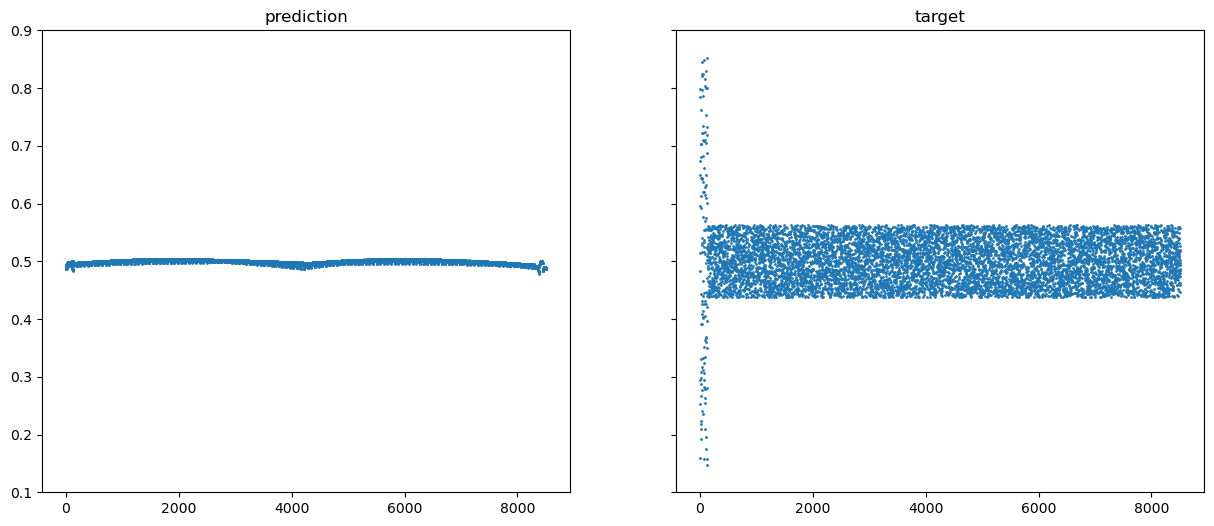

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

#### Replace old weights with new predicted weights in CPPN1 layer by layer

In [18]:
prediction.mul_(2).sub_(1)
index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquared_output.pt")

128
tensor([[-0.0279, -0.0170],
        [-0.0271, -0.0157],
        [-0.0263, -0.0145],
        [-0.0256, -0.0133],
        [-0.0248, -0.0123],
        [-0.0241, -0.0113],
        [-0.0233, -0.0103],
        [-0.0226, -0.0094],
        [-0.0219, -0.0086],
        [-0.0212, -0.0079],
        [-0.0205, -0.0072],
        [-0.0198, -0.0065],
        [-0.0191, -0.0059],
        [-0.0185, -0.0054],
        [-0.0178, -0.0050],
        [-0.0172, -0.0046],
        [-0.0165, -0.0042],
        [-0.0159, -0.0039],
        [-0.0153, -0.0037],
        [-0.0147, -0.0035],
        [-0.0141, -0.0033],
        [-0.0135, -0.0033],
        [-0.0129, -0.0032],
        [-0.0123, -0.0032],
        [-0.0118, -0.0033],
        [-0.0112, -0.0034],
        [-0.0107, -0.0035],
        [-0.0101, -0.0037],
        [-0.0096, -0.0040],
        [-0.0091, -0.0043],
        [-0.0086, -0.0046],
        [-0.0081, -0.0049],
        [-0.0076, -0.0054],
        [-0.0072, -0.0058],
        [-0.0067, -0.0063],
        [-0.0063